In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 
start_time = time.time()

In [2]:
df_fuel_trans = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv')
df_truck_info = pd.read_csv('data/IBGEFILE.UNITS.csv')
df_fuel_opt = pd.read_csv('data/BGEIDSC.EF2EFFP.csv')
df_level = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv')
df_events = pd.read_csv('data/Extranet2.ExactFuelEvents.csv')
df_performance = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv')
df_events = df_events.drop(columns=['EquipmentType']) ## - 1 unique entry
df_event_level = pd.merge(df_events, df_level, how='left', left_on='ESS_Id', right_on='ExactFuelEventId')

In [102]:
fuels = ['ULSD', 'FUEL', 'CDSL', 'DEFC', 'DSL1', 'BDSL']

In [3]:
driver_events = df_events.DriverID.value_counts().sort_values(ascending=False)

In [4]:
driver_events

DYET          33901
SIMJIM        27204
VAUJAM        25743
ULAL          25584
ECKS          24125
CHAJO         23895
OBRG          23551
BULR          23042
CUNW          22963
RENT          22957
LOVH          22395
BROD03        22313
PERT          22190
FARMI         22039
STEGA         21968
CHRN          21921
NARJ          21574
GALJU         21530
SWEJ          21140
ANTR          21046
TAYJON        20882
EDWTI         20845
SAVE          20688
FERCA         20550
SIMJE         20529
STOD          20443
DINE          20246
MORJAM        20216
CRES          19957
JENLE         19871
              ...  
SHOP3            52
BANJA            51
DENJE            48
CARJ01           48
REERO            42
STAW             41
SNID             22
ADADE            20
RUDD             17
MEID             12
JOHLO            11
CRAIG B          10
SCHJ             10
GODJO             2
BYRCHI            2
KINCA             2
WILRON            2
HARGR             2
SHOP!             2


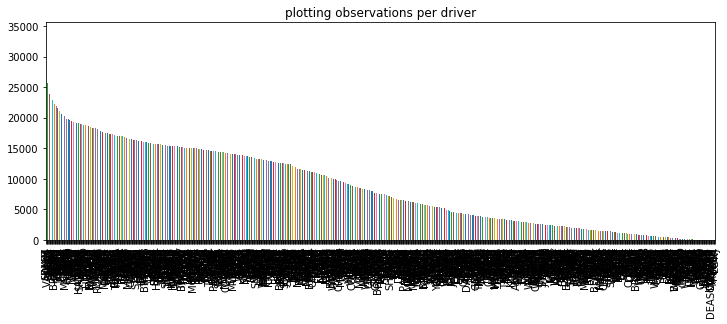

In [5]:
driver_events.plot(kind='bar', figsize=(12,4), title='plotting observations per driver');

In [6]:
#driver_events.plot(kind='hist', bins=95, title='table observations by driver');

In [7]:
#start_time_a = time.time()
#
#_ = plt.hist(driver_events, bins=50)
#plt.show()

#print (time.time() - start_time_a)

In [8]:
#fg = sns.FacetGrid(data=df_events, hue='EquipmentID')
#fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

In [9]:
truck_1713 = df_event_level.loc[(df_event_level['EquipmentID'] == 1713) & (df_event_level['IgnitionStatus'] == 1)] 

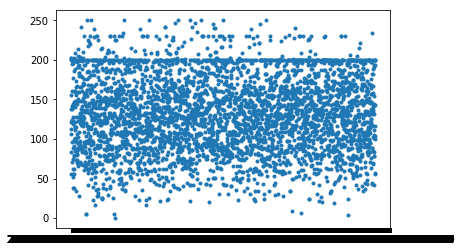

In [10]:
plt.plot(truck_1713.EventTimeStamp, truck_1713.TankLevelGallons, marker='.', linestyle='none') 
plt.show()
## redo with fuel levels ##

In [11]:
truck_1713_dec = truck_1713
truck_1713_dec['fuel_delta'] = truck_1713_dec.TankLevelGallons - truck_1713_dec.TankLevelGallons.shift(1)
truck_1713_dec['odometer_delta'] = truck_1713_dec.Odometer - truck_1713_dec.Odometer.shift(1)
truck_1713_dec['mpg_change'] = truck_1713_dec.odometer_delta / truck_1713_dec.fuel_delta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [37]:
truck_1713_dec[['TankLevelGallons','EventTimeStamp','Odometer', 'odometer_delta', 'fuel_delta','mpg_change', 'EFReportReason']]

,TankLevelGallons,EventTimeStamp,Odometer,odometer_delta,fuel_delta,mpg_change,EFReportReason
2,121.80,2017-01-01 00:04:15.053,377577.4,NaN,NaN,NaN,2
90,155.40,2017-01-01 01:04:15.443,377644.0,66.6,33.60,1.982143,2
115,199.40,2017-01-01 01:24:45.490,377665.4,21.4,44.00,0.486364,2
129,55.80,2017-01-01 01:37:55.430,377666.9,1.5,-143.60,-0.010446,0
141,106.80,2017-01-01 01:52:55.443,377681.9,15.0,51.00,0.294118,2
148,202.63,2017-01-01 01:58:25.507,377682.2,0.3,95.83,0.003131,0
179,202.63,2017-01-01 01:58:25.507,377682.2,0.0,0.00,NaN,0
193,83.60,2017-01-01 02:13:25.587,377687.8,5.6,-119.03,-0.047047,2
217,137.40,2017-01-01 02:28:25.803,377701.3,13.5,53.80,0.250929,2
218,112.00,2017-01-01 02:46:15.850,377715.6,14.3,-25.40,-0.562992,2


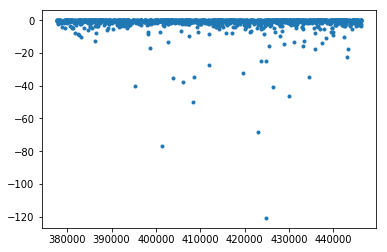

In [13]:
truck_1713_map = truck_1713_dec
truck_1713_map = truck_1713_map[truck_1713_map['mpg_change'] < 0]
plt.plot(truck_1713_map.Odometer, truck_1713_map.mpg_change, marker='.', linestyle='none')
plt.show()

In [14]:
#plt.plot(truck_1713_map.Odometer, truck_1713_map.TankLevelGallons, marker='.', linestyle='none')
#plt.show()


In [15]:
truck_1713_map_wSpeed = truck_1713_map[truck_1713_map['Speed'] > 0]

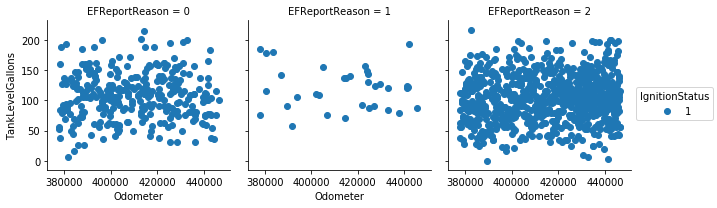

In [16]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'Odometer', 'TankLevelGallons').add_legend()

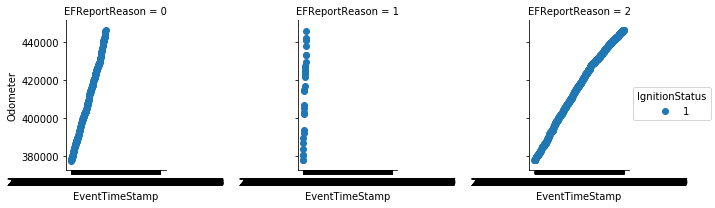

In [19]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

In [49]:
from datetime import timezone
truck_1713_map_wSpeed['EventTimeStamp'] = pd.to_datetime(truck_1713_map_wSpeed['EventTimeStamp'])

In [50]:
truck_1713_map_wSpeed = truck_1713_map_wSpeed.sort_values(by=['EventTimeStamp'])

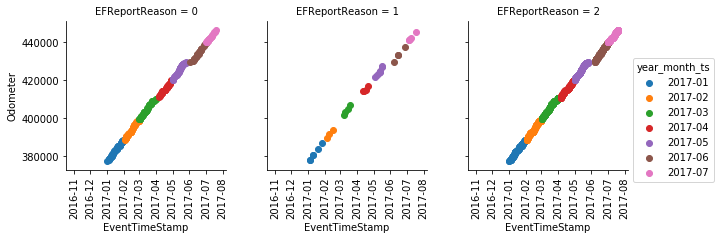

In [53]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='year_month_ts', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 90);

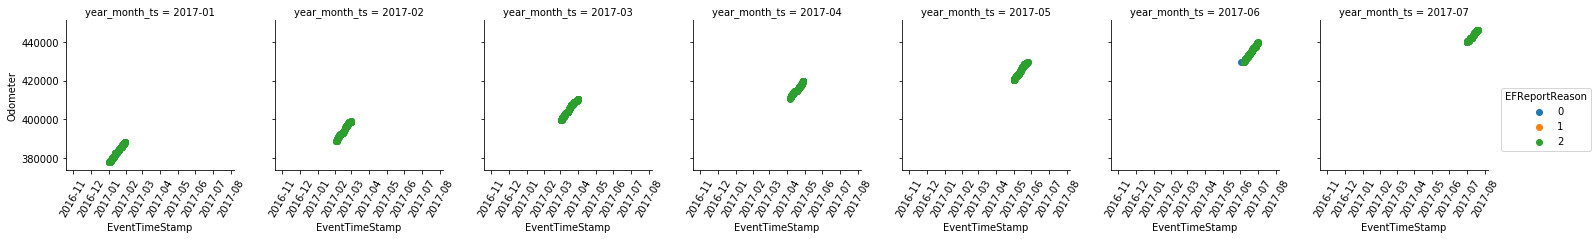

In [59]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='EFReportReason', col='year_month_ts')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 60);

In [ ]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='EFReportReason', col='year_month_ts')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 60);

In [52]:
truck_1713_map_wSpeed.head()

,Id_x,ESS_Id,EventTimeStamp,EquipmentID,MCTNumber,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,...,EFReportReason,Id_y,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,fuel_delta,odometer_delta,mpg_change,year_month_ts
129,12649235,13640422,2017-01-01 01:37:55.430,1713,105438293,RUSR,34.63710,-84.97768,2017-01-01 01:37:57.000,67,...,0,11282929.0,1.0,27.9,55.8,13640422.0,-143.60,1.5,-0.010446,2017-01
193,12649299,13640479,2017-01-01 02:13:25.587,1713,105438293,RUSR,34.45262,-84.87518,2017-01-01 02:13:27.000,61,...,2,11282986.0,1.0,41.8,83.6,13640479.0,-119.03,5.6,-0.047047,2017-01
218,12649324,13640521,2017-01-01 02:46:15.850,1713,105438293,RUSR,34.46862,-84.49788,2017-01-01 02:42:22.000,9,...,2,11283028.0,1.0,56.0,112.0,13640521.0,-25.40,14.3,-0.562992,2017-01
15735,12664956,13657294,2017-01-02 19:53:41.533,1713,105438293,RUSR,33.81130,-84.25105,2017-01-02 19:53:44.000,61,...,2,11298415.0,1.0,24.8,62.0,13657294.0,-66.00,13.5,-0.204545,2017-01
16099,12665320,13657671,2017-01-02 20:53:41.953,1713,105438293,RUSR,34.42607,-84.41943,2017-01-02 20:53:44.000,41,...,2,11298792.0,1.0,18.9,37.8,13657671.0,-24.20,61.8,-2.553719,2017-01


In [122]:
#df_fuel_trans
df_fuel_trans_fuels = df_fuel_trans[df_fuel_trans['TRNPI1'].isin(fuels)]
df_fuel_trans_fuels = df_fuel_trans_fuels.drop(columns=['TRNPI2','TRNPI3','TRNPI4','TRNPI5','TRNPI6','TRNPQ2','TRNPQ3','TRNPQ4','TRNPQ5','TRNPQ6'])

In [126]:
from datetime import datetime
datetime.strptime(df_fuel_trans_fuels['TRNDAT'], "%Y%M%D")

TypeError: strptime() argument 1 must be str, not Series

,TRNID,TRNDAT,TRNTIM,TRNTS#,TRNTSN,TRNSTC,TRNST,TRNDRI,TRNUNT,TRNPI1,TRNPQ1
1,42575331,20170101,48,516202,PILOT NEW BRAUNFELS 330,NEW BRAUNFELS,TX,MANRI,1584,ULSD,137.40
2,42578678,20170101,134,516277,PILOT 421,DALTON,GA,RUSR,1713,ULSD,137.93
3,42578722,20170101,137,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,FOSJA,1711,ULSD,45.00
4,42579695,20170101,302,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HICWIL,1837,ULSD,107.36
5,42579752,20170101,307,519125,PILOT #575,ST MARYS,GA,BATK,1992,ULSD,93.88
7,42580765,20170101,430,516304,PILOT GAFFNEY 453,GAFFNEY,SC,MARJOH,1730,ULSD,136.29
8,42580767,20170101,430,516156,PILOT CHARLOTTE 275,CHARLOTTE,NC,JAML,1672,ULSD,149.04
10,42580990,20170101,446,516113,PILOT 219,KNOXVILLE,TN,BEAKEV,1739,ULSD,99.85
11,42581101,20170101,453,516231,PILOT JACKSON 366,JACKSON,TN,MCAD,1585,ULSD,131.69
12,42581443,20170101,516,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,JARJ,1930,ULSD,90.62


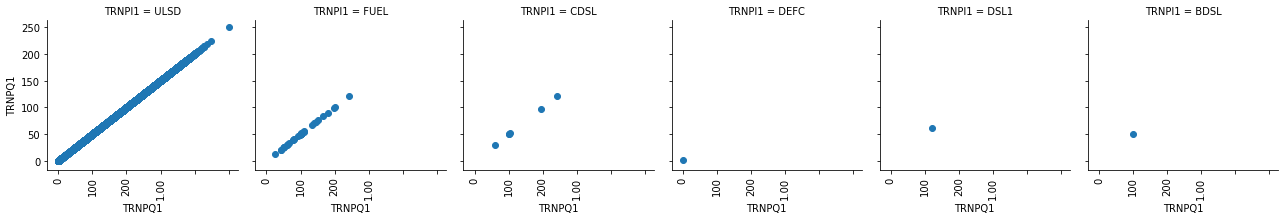

In [119]:
fg = sns.FacetGrid(data=df_fuel_trans_fuels, col='TRNPI1')
fg.map(plt.scatter,'TRNDAT','TRNPQ1')
fg.set_xticklabels(rotation = 90);

In [18]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 151.7779016494751 seconds ---
